# Lab 6

In [1]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [2]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

#### Q1. Write an SQL query to retrieve the yearly population for your state. 

In [3]:
query = """
SELECT p.year, p.pop
FROM population p
JOIN name n ON p.fips = n.fips
WHERE n.name = 'Vermont'
ORDER BY p.year;
"""

cur.execute(query)
rows = cur.fetchall()

for row in rows:
    print(f"Year: {row[0]}, Population: {row[1]}")


Year: 2005, Population: 602290
Year: 2006, Population: 623908
Year: 2007, Population: 621254
Year: 2008, Population: 621270
Year: 2009, Population: 621760
Year: 2010, Population: 625960
Year: 2011, Population: 626431
Year: 2012, Population: 626011
Year: 2013, Population: 626630
Year: 2014, Population: 626562
Year: 2015, Population: 626042
Year: 2016, Population: 624594
Year: 2017, Population: 623657
Year: 2018, Population: 626299
Year: 2019, Population: 623989


### Q1. Decide how to calculate year-over-year growth rate: Option B: compute growth rate in Python after loading population data

In [4]:
import pandas as pd

# Load SQL into DataFrame
query = """
SELECT p.year, p.pop
FROM population p
JOIN name n ON p.fips = n.fips
WHERE n.name = 'Vermont'
ORDER BY p.year;
"""
df = pd.read_sql_query(query, conn)

# Calculate year-over-year growth
df['growth_rate_percent'] = df['pop'].pct_change() * 100

print(df)


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


    year     pop  growth_rate_percent
0   2005  602290                  NaN
1   2006  623908             3.589301
2   2007  621254            -0.425383
3   2008  621270             0.002575
4   2009  621760             0.078871
5   2010  625960             0.675502
6   2011  626431             0.075244
7   2012  626011            -0.067046
8   2013  626630             0.098880
9   2014  626562            -0.010852
10  2015  626042            -0.082993
11  2016  624594            -0.231294
12  2017  623657            -0.150017
13  2018  626299             0.423630
14  2019  623989            -0.368833


/tmp/ipykernel_7345/3825818760.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


### Q1. Use Jupyter AI to help write the Python code that loads the results and creates a line chart with the growth rate

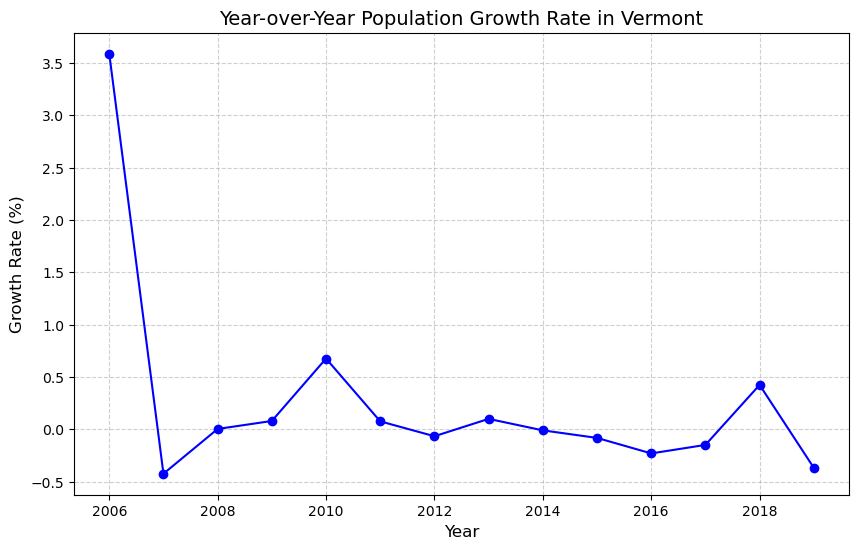

In [5]:
import matplotlib.pyplot as plt


state_name = 'Vermont'  

plt.figure(figsize=(10, 6))

plt.plot(df['year'], df['growth_rate_percent'], marker='o', linestyle='-', color='blue')

plt.title(f'Year-over-Year Population Growth Rate in {state_name}', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Growth Rate (%)', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


### Q1: Chart explanation, From 2019 to 2019 the growth rate fluctuations of Vermont were relativly minor, never going above or below 1% year over year. Certain growth rate percentages, namely the growth in 2010 and 2018 reflect positive years for the Vermont economy, yet these jumps in population growths were temporary becuase the years following the population growth went back down.  

### Q2. Write an SQL query to join the income and population tables for your state, selecting values for all years

In [6]:
import pandas as pd

query = """
SELECT 
    p.year,
    p.pop,
    i.income
FROM 
    population p
JOIN 
    income i 
    ON p.fips = i.fips AND p.year = i.year
JOIN 
    name n 
    ON p.fips = n.fips
WHERE 
    n.name = 'Vermont'
ORDER BY 
    p.year;
"""

# Load the query into a DataFrame
df = pd.read_sql_query(query, conn)

print(df)


    year     pop  income
0   2005  602290   45686
1   2006  623908   47665
2   2007  621254   49907
3   2008  621270   52104
4   2009  621760   51618
5   2010  625960   49406
6   2011  626431   52776
7   2012  626011   52977
8   2013  626630   52578
9   2014  626562   54166
10  2015  626042   56990
11  2016  624594   57677
12  2017  623657   57513
13  2018  626299   60782
14  2019  623989   63001


/tmp/ipykernel_7345/3338021131.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


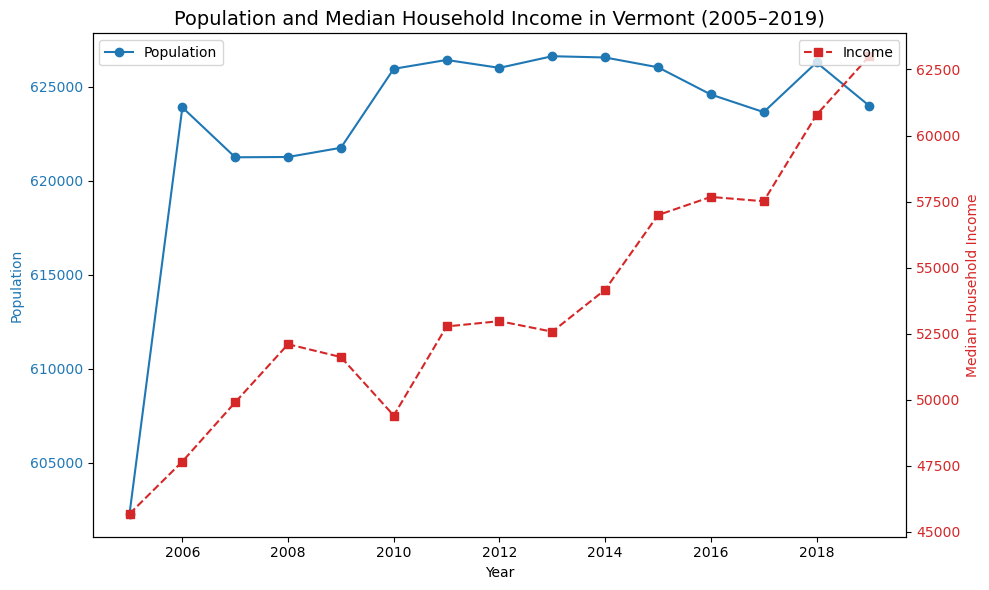

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
    'pop': [602290, 623908, 621254, 621270, 621760, 625960, 626431, 626011, 626630, 626562, 626042, 624594, 623657, 626299, 623989],
    'income': [45686, 47665, 49907, 52104, 51618, 49406, 52776, 52977, 52578, 54166, 56990, 57677, 57513, 60782, 63001]
}

df = pd.DataFrame(data)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot population (left axis)
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color=color)
ax1.plot(df['year'], df['pop'], color=color, marker='o', label='Population')
ax1.tick_params(axis='y', labelcolor=color)

# Plot income (right axis)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Median Household Income', color=color)
ax2.plot(df['year'], df['income'], color=color, marker='s', linestyle='--', label='Income')
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Population and Median Household Income in Vermont (2005–2019)', fontsize=14)
fig.tight_layout()

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


### Q2: Markdown Explanation, Between 2007-2009 the difference between the population and median household income was relativly consistent. In 2010 we notice a small drop in median household income compared to the previous year, but the population of Vermont increase about 5,000 from the previous year. Over the course of the years 2005-2019, the median household income of Vermont as on aveverage increased, with population in the years 2010-2019 satying consistent.

### Q3:"How has median household income in Vermont changed from year to year?"

### Q3: Write code to retrieve the data

In [26]:
query = """
SELECT 
    p.year,
    p.pop,
    i.income,
    (i.income - LAG(i.income) OVER (ORDER BY p.year)) AS income_change
FROM 
    population p
JOIN 
    income i 
    ON p.fips = i.fips AND p.year = i.year
JOIN 
    name n 
    ON p.fips = n.fips
WHERE 
    n.name = 'Vermont'
ORDER BY 
    p.year;
"""

df = pd.read_sql_query(query, conn)
print(df)

    year     pop  income  income_change
0   2005  602290   45686            NaN
1   2006  623908   47665         1979.0
2   2007  621254   49907         2242.0
3   2008  621270   52104         2197.0
4   2009  621760   51618         -486.0
5   2010  625960   49406        -2212.0
6   2011  626431   52776         3370.0
7   2012  626011   52977          201.0
8   2013  626630   52578         -399.0
9   2014  626562   54166         1588.0
10  2015  626042   56990         2824.0
11  2016  624594   57677          687.0
12  2017  623657   57513         -164.0
13  2018  626299   60782         3269.0
14  2019  623989   63001         2219.0


/tmp/ipykernel_7345/3202362748.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


### Q3: Create a visualization of the data

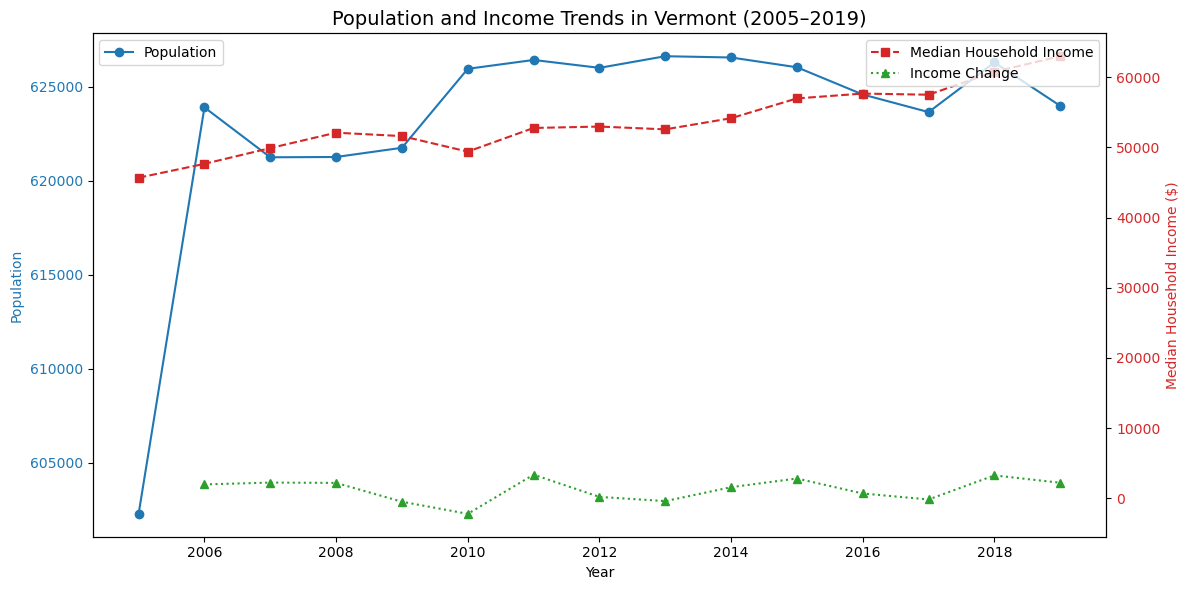

In [27]:
import matplotlib.pyplot as plt

# Plot setup
fig, ax1 = plt.subplots(figsize=(12, 6))

# Population line (left axis)
color = 'tab:blue'
ax1.plot(df['year'], df['pop'], color=color, marker='o', label='Population')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Income line (right axis)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(df['year'], df['income'], color=color, marker='s', linestyle='--', label='Median Household Income')
ax2.set_ylabel('Median Household Income ($)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Optional: plot income change as dotted line on secondary axis
color = 'tab:green'
ax2.plot(df['year'], df['income_change'], color=color, marker='^', linestyle=':', label='Income Change')

# Title and legends
plt.title('Population and Income Trends in Vermont (2005–2019)', fontsize=14)
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


### Q3: Provide a markdown explanation, From 2005 to 2019, Vermont’s population remained relatively stable, fluctuating around 620,000–626,000, with no dramatic growth or decline. Median household income showed a generally increasing trend, rising from $45,686  during 2005 to  $63,001 in 2019, though some years experienced minor declines, reflecting economic fluctuations. Year-to-year income changes indicate that while most years saw moderate increases, there were occasional decreases (e.g., 2009 and 2010), suggesting short-term economic setbacks, but the overall long-term trajectory is upward.